## Named Entity Recognition using Bidirectional LSTMs

In this notebook we train a bidirectional LSTM model for Named Entity Recognition on a Kaggle dataset.

Dataset from Kaggle: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Source website: https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [2]:
data = data.fillna(method="ffill")

In [3]:
data.tail(5)

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [5]:
n_words = len(words); n_words

35179

In [6]:
tags = list(set(data["Tag"].values))

In [7]:
n_tags = len(tags); n_tags

17

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)

In [10]:
sent = getter.get_next()

In [11]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [12]:
sentences = getter.sentences

In [13]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

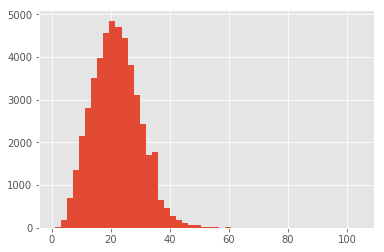

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

For the use of neural nets (at least with keras, this is no theoretical reason) we need to use equal-lenght input sequences. So we are going to pad our sentences to a length of 50. But first we need dictionaries of words and tags.

In [15]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
word2idx["Obama"]

26043

In [17]:
tag2idx["B-geo"]

4

Now we map the senctences to a sequence of numbers and then pad the sequence.

In [18]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [19]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [20]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [21]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [22]:
from keras.utils import to_categorical

For training the network we also need to change the labels y to categorial.

In [23]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [24]:
from sklearn.model_selection import train_test_split

In [34]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

Now we can fit a LSTM network with an embedding layer. Note that we used the functional API of keras here, as it is more suitable for complicated architectures.

In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [36]:
input = Input(shape=(max_len,))

model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(model)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [37]:
model = Model(input, out)

In [38]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=64, epochs=5, validation_split=0.3, verbose=1)

Train on 23499 samples, validate on 10072 samples
Epoch 1/5
17408/23499 [=====================>........] - ETA: 1:23 - loss: 0.3073 - acc: 0.9321

In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

Now let us look at some predictions.

In [ ]:
i = 1005
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, t, pred in zip(X_te[i], true, p[0]):
    print("{:15}: {:5} {}".format(words[w], tags[t], tags[pred]))